# MCMC for Wind Power Curve Estimation

In this notebook, a linear MCMC model for estimating power curve of wind turbines are developed. The probabilistic model can estimate the epistemic uncertainty of the generated power. The dataset comes form windfarm open dataset published by ENGIE and available at:

https://opendata-renewables.engie.com/explore/index

The code is inspired by a tensorflow probability taturial available at: 

https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer







In [1]:
import collections
import os
from six.moves import urllib
import daft as daft
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
tfb = tfp.bijectors

warnings.simplefilter('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# We'll use the following directory to store files we download as well as our
# preprocessed dataset.

WindFarmData = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Hirerchial Model/Wind Turbine Data PreProcessed 2013-2018 All Data.csv')
def time_feature_encoding(df):
    df.loc[:,'year'] = pd.to_datetime(df['Date_time']).dt.year
    df.loc[:,'season'] = pd.to_datetime(df['Date_time']).dt.month%12 + 3//3
    df.loc[:,'Weekday'] = pd.to_datetime(df['Date_time']).dt.weekday
    df.loc[:,'month'] = pd.to_datetime(df['Date_time']).dt.month   

time_feature_encoding(WindFarmData)  
WindFarmData = WindFarmData[(WindFarmData['Ws_avg'] > 4) & (WindFarmData['Ws_avg'] < 14) & (WindFarmData['year'] == 2017) & (WindFarmData['season'] == 1) & (WindFarmData['P_avg'] >100)].sample(300)
WindFarmData['Ws_avg'] = WindFarmData['Ws_avg'] / WindFarmData['Ws_avg'].max()
WindFarmData['P_avg'] = WindFarmData['P_avg'] / WindFarmData['P_avg'].max()

dfList = []
for ID in WindFarmData['TurbineID'].unique():
  dfList.append(WindFarmData[WindFarmData['TurbineID'] == ID])
X_list = []
y_list = []
for df in dfList:
  X_list.append(tf.convert_to_tensor(df['Ws_avg'], dtype=tf.float32))
  y_list.append(tf.convert_to_tensor(df['P_avg'], dtype=tf.float32))

X = tf.convert_to_tensor(WindFarmData['Ws_avg'], dtype=tf.float32)
y = tf.convert_to_tensor(WindFarmData['P_avg'], dtype=tf.float32)

In [4]:
num_counties = WindFarmData['TurbineID'].nunique()
num_observations = len(X)

In [5]:
for df in dfList:
  print(df.describe())

          Unnamed: 0     Ws_avg      Wa_avg  ...  season    Weekday  month
count      76.000000  76.000000   76.000000  ...    76.0  76.000000   76.0
mean   248574.118421   0.525215  207.761053  ...     1.0   2.986842   12.0
std     14799.872974   0.157382   64.169904  ...     0.0   1.956142    0.0
min    217261.000000   0.338813   14.540000  ...     1.0   0.000000   12.0
25%    237724.250000   0.404753  176.312500  ...     1.0   1.000000   12.0
50%    251952.500000   0.484274  203.970000  ...     1.0   3.000000   12.0
75%    262423.250000   0.628306  246.255000  ...     1.0   5.000000   12.0
max    264074.000000   0.982130  359.990000  ...     1.0   6.000000   12.0

[8 rows x 17 columns]
          Unnamed: 0     Ws_avg      Wa_avg  ...  season    Weekday  month
count      96.000000  96.000000   96.000000  ...    96.0  96.000000   96.0
mean   248344.645833   0.563393  217.022812  ...     1.0   3.333333   12.0
std     12312.466801   0.177302   66.343156  ...     0.0   2.060489    0.0
mi

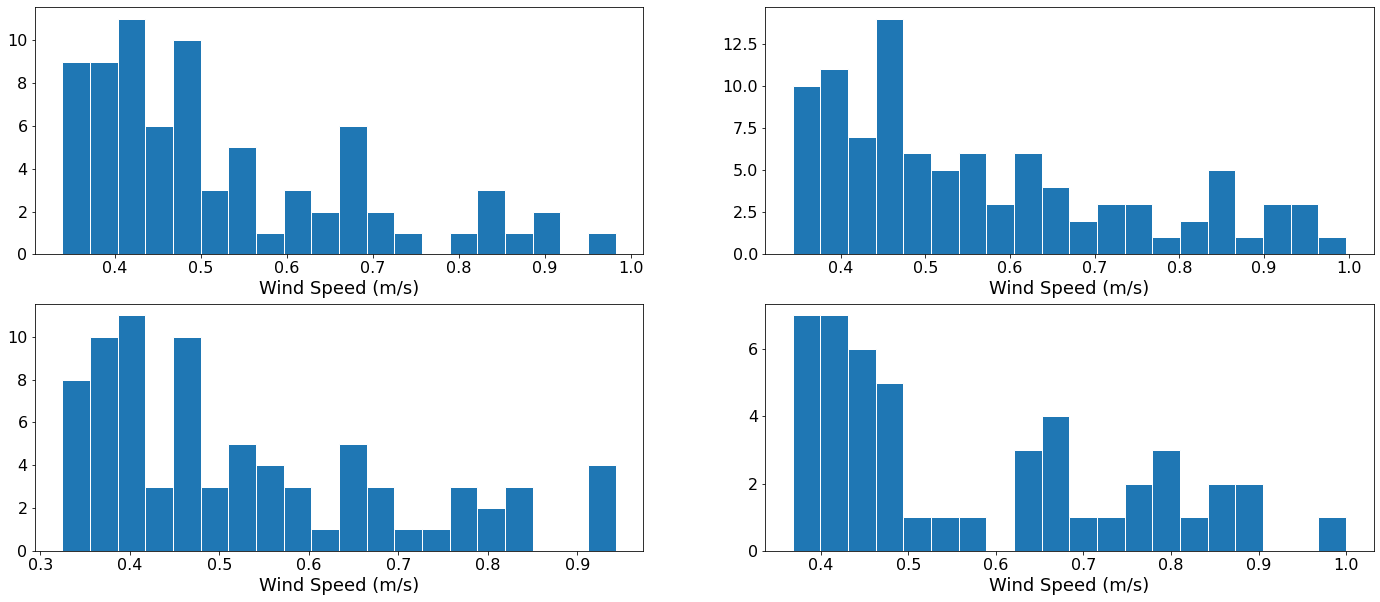

In [6]:
fig,axs = plt.subplots(2,2, figsize = (24,10))
for ax, X_ in zip(axs.reshape(-1),X_list):
  ax.hist(X_.numpy() * WindFarmData['Ws_avg'].max(), bins=20, edgecolor='white')
  ax.set_xlabel('Wind Speed (m/s)',fontsize=18)
  ax.tick_params(axis='both', which='major', labelsize=16)

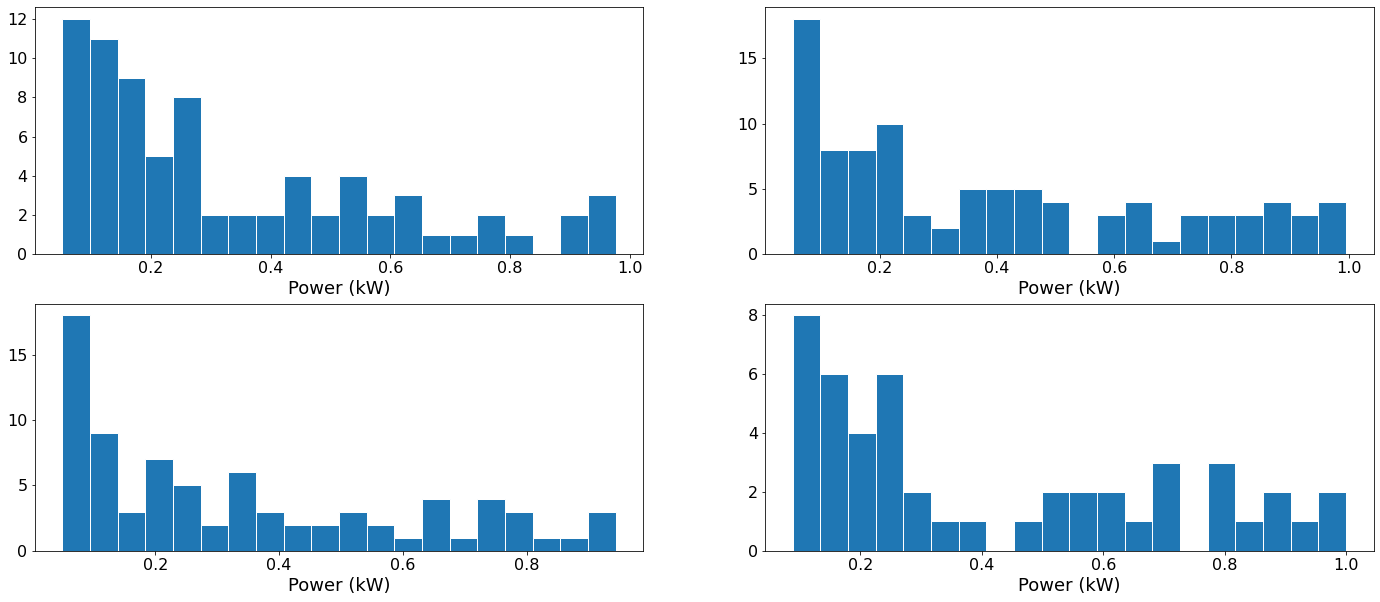

In [7]:
fig,axs = plt.subplots(2,2, figsize = (24,10))
for ax, y_ in zip(axs.reshape(-1),y_list):
  ax.hist(y_.numpy()*WindFarmData['P_avg'].max(), bins=20, edgecolor='white')
  ax.set_xlabel('Power (kW)',fontsize=18)
  ax.tick_params(axis='both', which='major', labelsize=16)

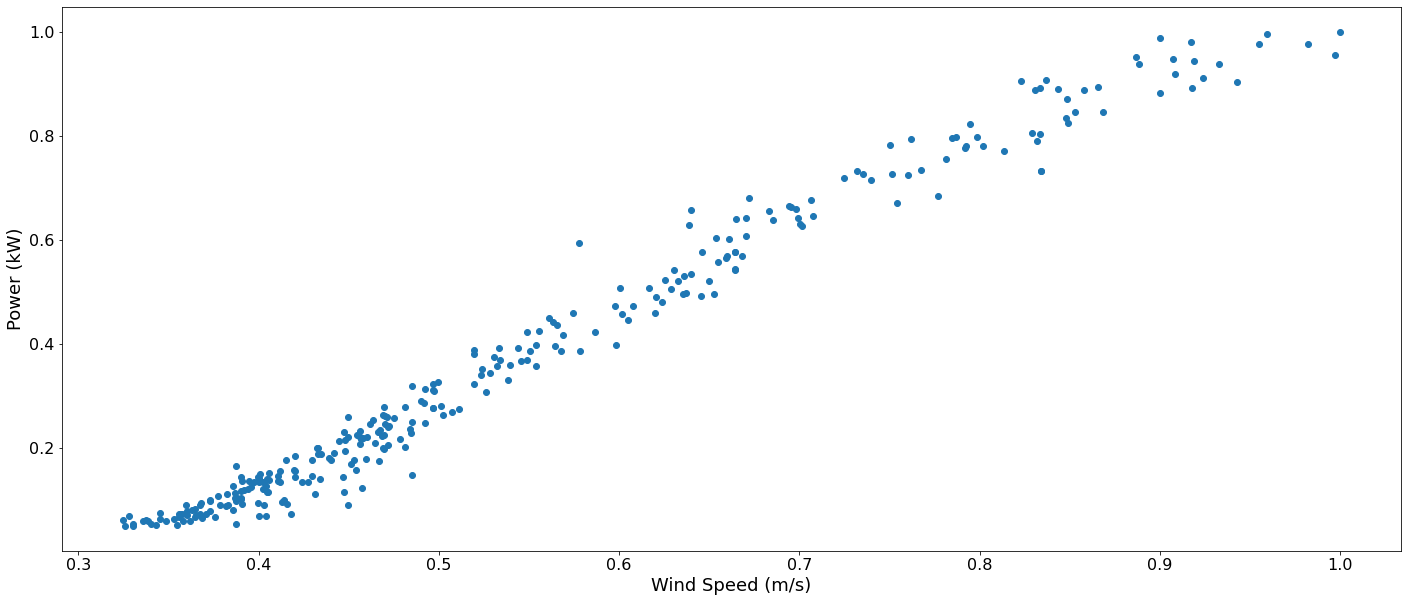

In [8]:
fig,ax = plt.subplots(1,1,figsize = (24,10))
ax.scatter(X.numpy()*WindFarmData['Ws_avg'].max(), y.numpy()*WindFarmData['P_avg'].max())
ax.set_ylabel('Power (kW)',fontsize=18)
ax.set_xlabel('Wind Speed (m/s)',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

In [9]:
@tf.function
def affine(x,kernel_diag_1, bias=tf.zeros([])):
  """`kernel_diag * x + bias` with broadcasting."""
  kernel_diag_1 = tf.ones_like(x) * kernel_diag_1


  bias = tf.ones_like(x) * bias
  return  x * kernel_diag_1 + bias

In [10]:
def pooled_model(X):
  """Creates a joint distribution representing our generative process."""
  return tfd.JointDistributionSequential([

      tfd.Normal(loc=0., scale=1e4),  # beta1
      tfd.Normal(loc=0., scale=1e4),  # beta0
      
      tfd.HalfCauchy(loc=0., scale=5),  # sigma
      lambda s , b1 , b0: tfd.MultivariateNormalDiag(  # y
          loc=affine(X, b1[..., tf.newaxis],b0[..., tf.newaxis]),
          scale_identity_multiplier=s)
  ])


@tf.function
def pooled_log_prob(beta1, beta0, sigma):
  """Computes `joint_log_prob."""
  return pooled_model(X).log_prob([beta1, beta0, sigma, y])

In [11]:
@tf.function
def sample_pooled(num_chains, num_results, num_burnin_steps, num_observations):
  """Samples from the pooled model."""
  hmc = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=pooled_log_prob,
      
      step_size=0.001)

  initial_state = [

      tf.zeros([num_chains], name='init_beta1'),
      tf.zeros([num_chains], name='init_beta0'),
      
      tf.ones([num_chains], name='init_sigma')
  ]

  # Contrain `sigma` to the positive real axis. Other variables are
  # unconstrained.
  unconstraining_bijectors = [
      tfb.Identity(),  # beta1
      tfb.Identity(),  # beta0
      tfb.Exp()        # sigma
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)

  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [12]:
PooledModel = collections.namedtuple('PooledModel', [ 'beta1', 'beta0', 'sigma'])

samples, acceptance_probs = sample_pooled(
    num_chains=4,
    num_results=2000,
    num_burnin_steps=2000,
    num_observations=num_observations)

print('Acceptance Probabilities for each chain: ', acceptance_probs.numpy())
pooled_samples = PooledModel._make(samples)

Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
Acceptance Probabilities for each chain:  [1. 1. 1. 1.]


In [13]:
for var, var_samples in pooled_samples._asdict().items():
  print('R-hat for ', var, ':\t',
        tfp.mcmc.potential_scale_reduction(var_samples).numpy())

R-hat for  beta1 :	 1.0009547
R-hat for  beta0 :	 1.0008332
R-hat for  sigma :	 1.0045735


In [14]:
def reduce_samples(var_samples, reduce_fn):
  """Reduces across leading two dims using reduce_fn. """
  # Collapse the first two dimensions, typically (num_chains, num_samples), and
  # compute np.mean or np.std along the remaining axis.
  if isinstance(var_samples, tf.Tensor):
    var_samples = var_samples.numpy() # convert to numpy array
  var_samples = np.reshape(var_samples, (-1,) +  var_samples.shape[2:])
  return np.apply_along_axis(reduce_fn, axis=0, arr=var_samples)

sample_mean = lambda samples : reduce_samples(samples, np.mean)

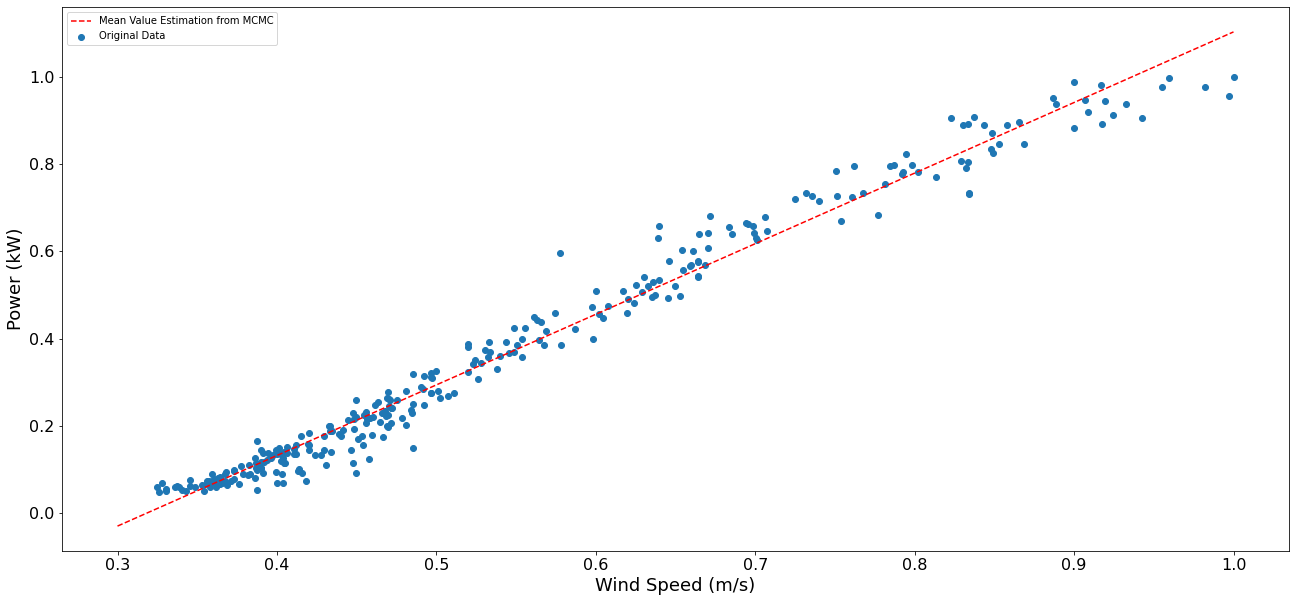

In [15]:
LinearEstimates = collections.namedtuple('LinearEstimates',
                                        ['b0', 'b1'])

pooled_estimate = LinearEstimates(
  b0 = sample_mean(pooled_samples.beta1),
  b1 = sample_mean(pooled_samples.beta0)
)

fig,ax = plt.subplots(1,1,figsize = (22,10))
ax.scatter(X, y, label = 'Original Data')
xvals = np.linspace(0.3, 1)
ax.set_ylabel('Power (kW)',fontsize=18)
ax.set_xlabel('Wind Speed (m/s)',fontsize=18)
ax.plot(xvals, pooled_estimate.b1 * xvals + pooled_estimate.b0 , 'r--', label = 'Mean Value Estimation from MCMC')
ax.legend()
ax.tick_params(axis='both', which='major', labelsize=16)

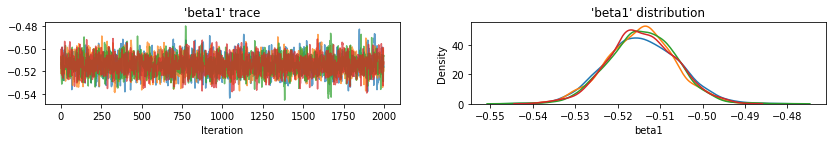

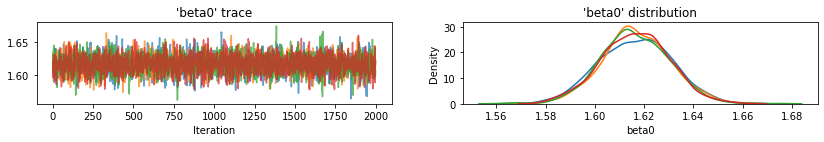

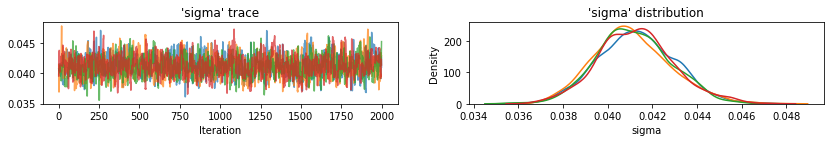

In [16]:
#@title Utility function to plot traces of sampled variables.
def plot_traces(var_name, samples, num_chains):
  if isinstance(samples, tf.Tensor):
    samples = samples.numpy() # convert to numpy array
  fig, axes = plt.subplots(1, 2, figsize=(14, 1.5), sharex='col', sharey='col')
  for chain in range(num_chains):
    axes[0].plot(samples[:, chain], alpha=0.7)
    axes[0].title.set_text("'{}' trace".format(var_name))
    sns.kdeplot(samples[:, chain], ax=axes[1], shade=False)
    axes[1].title.set_text("'{}' distribution".format(var_name))
    axes[0].set_xlabel('Iteration')
    axes[1].set_xlabel(var_name)
  plt.show()

for var, var_samples in pooled_samples._asdict().items():
  plot_traces(var, samples=var_samples, num_chains=4)